Using device: cuda:0
--- Training Base Model ---


Training Base: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 203.98it/s]


Base model training complete.

--- Running Experiment 1: FID vs. w ---


Sweeping s_scale for FID: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:30<00:00, 75.03s/it]


Experiment 1 finished.

--- Running Experiment 2: Cosine Similarity vs. s_scale ---


Sweeping s_scale for Cosine Similarity: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:40<00:00,  2.19s/it]


Experiment 2 finished.

--- Plotting Results (Diffusion) — tagged ---


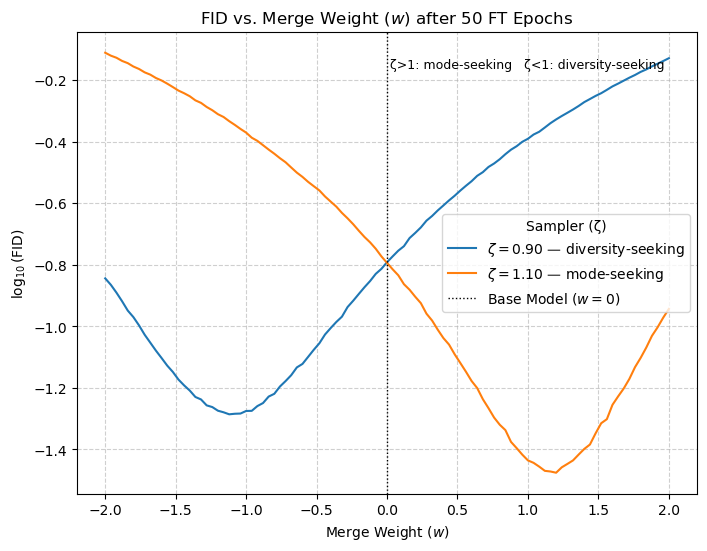

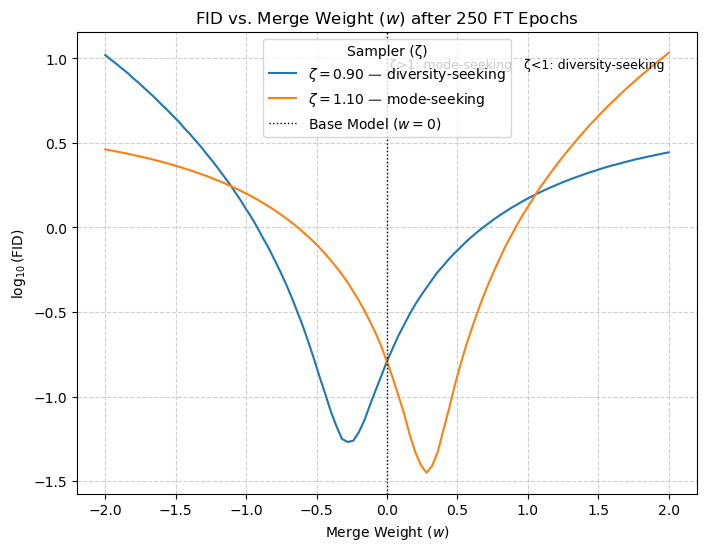

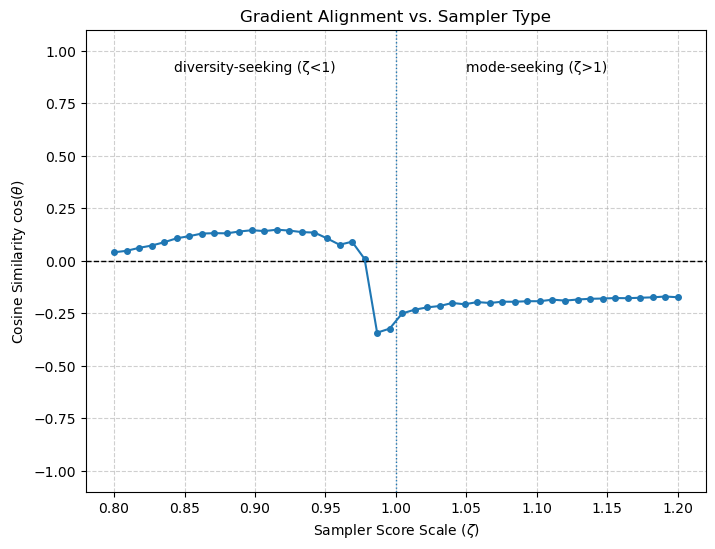


Done.


In [22]:
# ============================================================
# Neon toy with a tiny Diffusion model + score scale (ζ)
# ============================================================
# What this script does:
# 1) Train a small diffusion ε-predictor (MLP) on a 2D Gaussian target.
# 2) Generate a synthetic set with a score scale ζ:
#       - ζ > 1  => mode-seeking (pushes toward denser regions)
#       - ζ < 1  => diversity-seeking (spreads mass)
# 3) Short self-training on the synthetic set.
# 4) Neon merge: θ_neon = θ_r - w (θ_s - θ_r). Sweep w and plot FID.
# 5) Compute a P-weighted gradient cosine between real and synthetic gradients
#    at θ_r as ζ varies to verify anti-alignment (ζ>1 ⇒ negative cosine).
# 6) Plot results with **clear ζ tags** (no CSV saving).
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import transforms
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import copy
import scipy.linalg

# ---------- Params ----------
device_str = "cuda:0"
diffusion_steps = 1000
FID_SAMPLES = 1_000_000   # Large for very low-variance FID in 2D (can reduce to 20k–100k for speed)
N_base = 10**3
EPOCHS_BASE = 10_000
LR_BASE = 1e-4

# ---------- Repro / Device ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------- Target Gaussian ----------
D = 2
sigma_ref = np.array([[2.0, 1.0], [1.0, 2.0]], dtype=np.float64)
mu_ref = np.zeros((D,), dtype=np.float64)

# ---------- Schedules ----------
def make_cosine_schedule(n_steps: int, s: float = 0.008, device=None):
    device = device or torch.device("cpu")
    t = torch.arange(0, n_steps, dtype=torch.float32, device=device)
    schedule = torch.cos((t / n_steps + s) / (1 + s) * torch.pi / 2) ** 2
    baralphas = schedule / schedule[0]
    betas = 1.0 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
    alphas = 1.0 - betas
    return {"alphas": alphas, "betas": betas, "baralphas": baralphas}

train_sched = make_cosine_schedule(diffusion_steps, device=device)

# ---------- Model & Utilities ----------
def noise(Xbatch: torch.Tensor, t_idx: torch.Tensor, baralphas: torch.Tensor):
    baralpha_t = baralphas[t_idx.squeeze(-1)].unsqueeze(-1)
    eps = torch.randn_like(Xbatch)
    noised = baralpha_t.sqrt() * Xbatch + (1.0 - baralpha_t).sqrt() * eps
    return noised, eps

class DiffusionBlock(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.l = nn.Linear(n, n)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.l(x))

class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 4, nunits: int = 32):
        super().__init__()
        self.inb = nn.Linear(nfeatures + 1, nunits)
        self.mbs = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.out = nn.Linear(nunits, nfeatures)
    def forward(self, x: torch.Tensor, t: torch.Tensor, n_steps: int) -> torch.Tensor:
        if t.dtype not in (torch.float32, torch.float64):
            t = t.float()
        t_scaled = t / max(1, n_steps - 1)
        h = torch.hstack([x, t_scaled])
        h = self.inb(h)
        for block in self.mbs:
            h = block(h)
        return self.out(h)

@torch.no_grad()
def sample_diffusion(model: nn.Module, nsamples: int, nfeatures: int, n_steps: int, eta: float = 1.0, score_scale: float = 1.0) -> torch.Tensor:
    sched = make_cosine_schedule(n_steps, device=device)
    alphas, baralphas = sched["alphas"], sched["baralphas"]
    x = torch.randn((nsamples, nfeatures), device=device)

    for t in range(n_steps - 1, -1, -1):
        t_batch = torch.full((nsamples, 1), t, device=device, dtype=torch.long)
        eps_pred = model(x, t_batch, n_steps)
        
        bar_t = baralphas[t]
        bar_tm1 = baralphas[t-1] if t > 0 else torch.tensor(1.0, device=device)
        
        sqrt_bar_t = torch.sqrt(bar_t)
        sqrt_1m_bar_t = torch.sqrt(1.0 - bar_t)

        score = -eps_pred / (sqrt_1m_bar_t + 1e-9)
        score_scaled = score_scale * score
        
        x0_pred = (x + (1.0 - bar_t) * score_scaled) / (sqrt_bar_t + 1e-9)
        
        if t == 0:
            x = x0_pred
            break

        alpha_t = alphas[t]
        term1 = (1.0 - bar_tm1) / (1.0 - bar_t + 1e-9)
        term2 = 1.0 - alpha_t / (bar_t + 1e-9)
        sigma_t = eta * torch.sqrt(torch.clamp(term1 * term2, min=0.0))
        
        dir_coeff = torch.sqrt(torch.clamp(1.0 - bar_tm1 - sigma_t**2, min=0.0))
        
        mean = torch.sqrt(bar_tm1) * x0_pred + dir_coeff * eps_pred
        x = mean + (sigma_t * torch.randn_like(x) if (t > 0 and eta > 0.0) else 0.0)
    return x

def merge_models(base: nn.Module, other: nn.Module, w: float):
    m = copy.deepcopy(base)
    with torch.no_grad():
        for pm, pb, po in zip(m.parameters(), base.parameters(), other.parameters()):
            pm.copy_((1.0 + w) * pb - w * po)
    return m

# ---------- Metrics ----------
def calculate_fid(mu, sigma, mu_r, sigma_r) -> float:
    m = np.square(mu - mu_r).sum()
    s, _ = scipy.linalg.sqrtm(sigma @ sigma_r, disp=False)
    if not np.isfinite(s).all():
        return float('inf')
    return float(np.real(m + np.trace(sigma + sigma_r - 2.0 * s)))

def fid_of_model(model: nn.Module, nsamples: int, n_steps_infer: int) -> float:
    xs = sample_diffusion(model, nsamples, D, n_steps=n_steps_infer).cpu().numpy()
    if np.isnan(xs).any() or np.isinf(xs).any():
        return float('inf')
    return calculate_fid(xs.mean(0), np.cov(xs.T), mu_ref, sigma_ref)

# ===============================================
# ================== TRAIN BASE =================
# ===============================================
print("--- Training Base Model ---")
Xb = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, N_base).astype(np.float32))
base_model = DiffusionModel(D, nblocks=4).to(device)
opt = optim.Adam(base_model.parameters(), lr=LR_BASE)
loss_fn = nn.MSELoss()

for epoch in tqdm(range(EPOCHS_BASE), desc="Training Base"):
    for i in range(0, len(Xb), 2048):
        xb = Xb[i : i + 2048].to(device)
        t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
        noised, eps = noise(xb, t_idx, train_sched["baralphas"])
        pred = base_model(noised, t_idx, diffusion_steps)
        loss = loss_fn(pred, eps)
        opt.zero_grad()
        loss.backward()
        opt.step()
base_model.eval()
print("Base model training complete.")

# ===============================================
# === EXPERIMENT 1: FID vs. w ===
# ===============================================
print("\n--- Running Experiment 1: FID vs. w ---")
EPOCHS_LIST = [50, 250]
score_scales_fid = [0.9, 1.1]  # ζ<1: diversity-seeking, ζ>1: mode-seeking
LR_FT = 1e-5
N_aux = 10**3
ws_sweep = np.linspace(-2.0, 2.0, 101)
n_steps_eval = 20
results_fid = []

for s_scale in tqdm(score_scales_fid, desc="Sweeping s_scale for FID"):
    Xs = sample_diffusion(base_model, nsamples=N_aux, nfeatures=D, n_steps=n_steps_eval, score_scale=s_scale).cpu()
    aux_model = copy.deepcopy(base_model).train()
    opt_ft = optim.Adam(aux_model.parameters(), lr=LR_FT)
    max_epochs = max(EPOCHS_LIST)
    for epoch in range(1, max_epochs + 1):
        for i in range(0, len(Xs), 2048):
            xb = Xs[i : i + 2048].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            noised, eps = noise(xb, t_idx, train_sched["baralphas"])
            pred = aux_model(noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps)
            opt_ft.zero_grad(); loss.backward(); opt_ft.step()
        if epoch in EPOCHS_LIST:
            aux_model.eval()
            for w in ws_sweep:
                merged_model = merge_models(base_model, aux_model, w)
                fid = fid_of_model(merged_model, nsamples=FID_SAMPLES, n_steps_infer=n_steps_eval)
                results_fid.append({'epoch': epoch, 's_scale': s_scale, 'w': w, 'fid': fid})
            aux_model.train()

df_fid = pd.DataFrame(results_fid)
print("Experiment 1 finished.")

# ===============================================
# === EXPERIMENT 2: Cosine Similarity vs. s_scale ===
# ===============================================
print("\n--- Running Experiment 2: Cosine Similarity vs. s_scale ---")

def _avg_grad_over_dataset(model, X, batch_size=2048, n_t_samples=16):
    model.train()
    loss_fn = nn.MSELoss()
    per_param_grads = [torch.zeros_like(p, device=device) for p in model.parameters()]
    n_batches = (len(X) + batch_size - 1) // batch_size
    for _ in range(n_t_samples):
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            x_noised, eps = noise(xb, t_idx, train_sched["baralphas"])
            model.zero_grad()
            pred = model(x_noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps)
            loss.backward()
            for acc, p in zip(per_param_grads, model.parameters()):
                if p.grad is not None: acc.add_(p.grad)
    for acc in per_param_grads: acc.div_(n_batches * n_t_samples)
    return [g.detach() for g in per_param_grads]

def _estimate_adam_preconditioner_diagonal(model, X, batch_size=2048, n_t_samples=16, betas=(0.9, 0.999), eps=1e-8):
    beta2 = betas[1]
    model.train()
    loss_fn = nn.MSELoss()
    v = [torch.zeros_like(p, device=device) for p in model.parameters()]
    steps = 0
    for _ in range(n_t_samples):
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            x_noised, eps_t = noise(xb, t_idx, train_sched["baralphas"])
            model.zero_grad()
            pred = model(x_noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps_t)
            loss.backward()
            for vv, p in zip(v, model.parameters()):
                if p.grad is not None: vv.mul_(beta2).addcmul_(p.grad, p.grad, value=(1.0 - beta2))
            steps += 1
    bc = 1.0 - (beta2 ** steps)
    for i in range(len(v)): v[i] = v[i] / bc
    return [1.0 / (torch.sqrt(vv) + eps) for vv in v]

# --- NEW HELPER FUNCTIONS FOR COSINE SIMILARITY ---
def _dot_with_P(g1_parts, g2_parts, P_diag_parts):
    s = 0.0
    for g1, g2, pd in zip(g1_parts, g2_parts, P_diag_parts):
        s += torch.sum(g1 * (pd * g2))
    return s.item()

def _norm_with_P(g_parts, P_diag_parts):
    norm_sq = 0.0
    for g, pd in zip(g_parts, P_diag_parts):
        norm_sq += torch.sum(g * (pd * g)) # This is <g, P g>
    return torch.sqrt(norm_sq).item()

S_SCALES_align = np.linspace(0.8, 1.2, 46)
N_pop = 100_000
N_syn = 100_000
n_steps_eval = 20  # reuse same eval steps as in Experiment 1

X_pop = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, size=N_pop).astype(np.float32))
g_d_pop_parts = _avg_grad_over_dataset(base_model, X_pop)
P_adam_diag_parts = _estimate_adam_preconditioner_diagonal(base_model, X_pop)
norm_d = _norm_with_P(g_d_pop_parts, P_adam_diag_parts)

cosine_similarities = []
for s_scale in tqdm(S_SCALES_align, desc="Sweeping s_scale for Cosine Similarity"):
    X_syn = sample_diffusion(base_model, nsamples=N_syn, nfeatures=D, n_steps=n_steps_eval, score_scale=s_scale)
    g_s_parts = _avg_grad_over_dataset(base_model, X_syn)
    
    # Calculate cosine similarity
    inner_product = _dot_with_P(g_d_pop_parts, g_s_parts, P_adam_diag_parts)
    norm_s = _norm_with_P(g_s_parts, P_adam_diag_parts)
    cos_sim = inner_product / (norm_d * norm_s + 1e-9)
    cosine_similarities.append(cos_sim)

df_align = pd.DataFrame({'s_scale': S_SCALES_align, 'cosine_similarity': cosine_similarities})
print("Experiment 2 finished.")

# ===============================================
# ================== PLOTTING ===================
# ===============================================
print("\n--- Plotting Results (Diffusion) — tagged ---")

def zeta_tag(z: float) -> str:
    # Diffusion convention: ζ>1 ⇒ mode-seeking, ζ<1 ⇒ diversity-seeking
    return "mode-seeking" if z > 1.0 else "diversity-seeking"

# -------- FID vs w (curves are tagged by ζ) --------
for epoch in sorted(df_fid['epoch'].unique()):
    plt.figure(figsize=(8, 6))
    epoch_df = df_fid[df_fid['epoch'] == epoch]
    for s_scale in sorted(epoch_df['s_scale'].unique()):
        subset = epoch_df[epoch_df['s_scale'] == s_scale]
        label = rf"$\zeta={s_scale:.2f}$ — {zeta_tag(float(s_scale))}"
        plt.plot(subset['w'], np.log10(subset['fid']), label=label)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(f"FID vs. Merge Weight ($w$) after {epoch} FT Epochs")
    plt.xlabel("Merge Weight ($w$)")
    plt.ylabel(r"$\log_{10}(\mathrm{FID})$")
    plt.axvline(0, color='k', linestyle=':', linewidth=1, label='Base Model ($w=0$)')
    # Annotate which ζ side is which
    ymin, ymax = plt.ylim()
    ytxt = ymax - 0.08 * (ymax - ymin)
    plt.text(0.02, ytxt, "ζ>1: mode-seeking   ζ<1: diversity-seeking", fontsize=9)
    plt.legend(title="Sampler (ζ)")
    plt.show()

# -------- Cosine similarity vs ζ (annotated regions) --------
plt.figure(figsize=(8, 6))
plt.plot(df_align['s_scale'], df_align['cosine_similarity'], marker='o', linestyle='-', markersize=4)
plt.axhline(0.0, color='k', linestyle="--", linewidth=1)
plt.axvline(1.0, linestyle=":", linewidth=1)

plt.xlabel(r"Sampler Score Scale ($\zeta$)")
plt.ylabel(r"Cosine Similarity $\cos(\theta)$")
plt.title("Gradient Alignment vs. Sampler Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-1.1, 1.1)

# Put labels at the top of the axes (inside the plot)
ax = plt.gca()
ax.text(0.25, 0.9, "diversity-seeking (ζ<1)", transform=ax.transAxes,
        ha="center", va="top", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
ax.text(0.75, 0.9, "mode-seeking (ζ>1)", transform=ax.transAxes,
        ha="center", va="top", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

plt.show()

print("\nDone.")


Using device: cuda:0
--- Training Base AR Model ---


Training Base: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.96it/s]


Base AR model training complete.
Base FID (τ_eval=1.0, seed=123): 0.099320

--- Running Experiment 1 (AR): FID vs. w ---
Experiment 1 finished.

--- Running Experiment 2 (AR): Cosine Similarity vs. τ ---


Sweeping τ for Cosine Similarity: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:12<00:00,  3.39it/s]


Experiment 2 finished.

--- Plotting Results (AR) ---


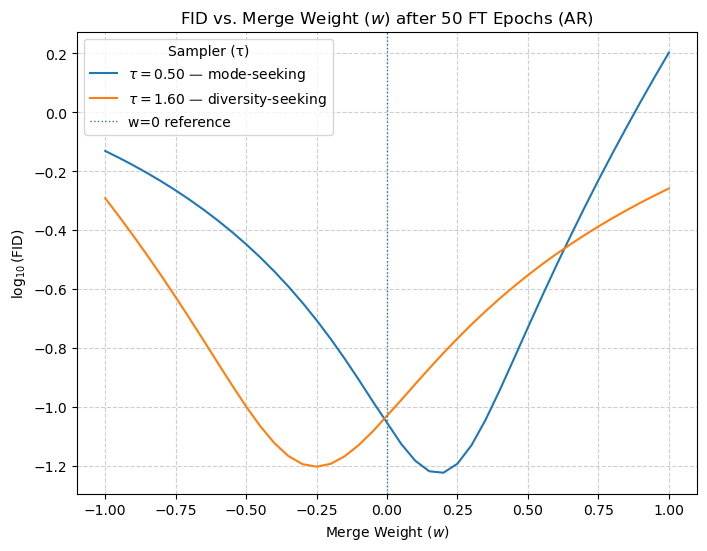

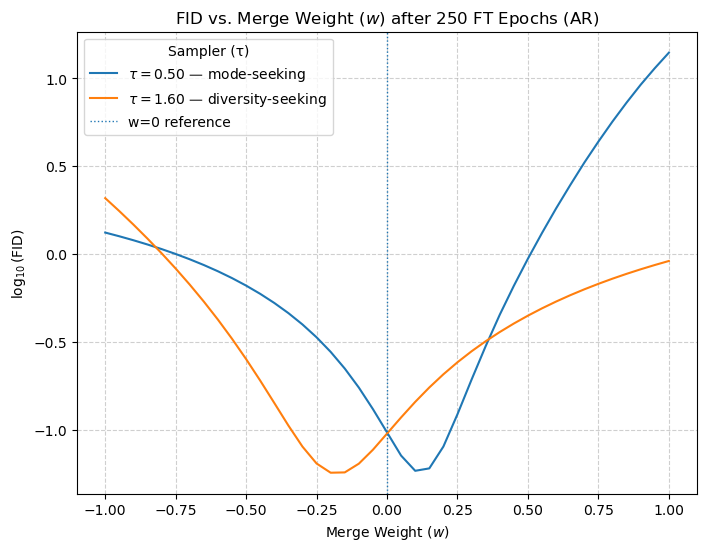

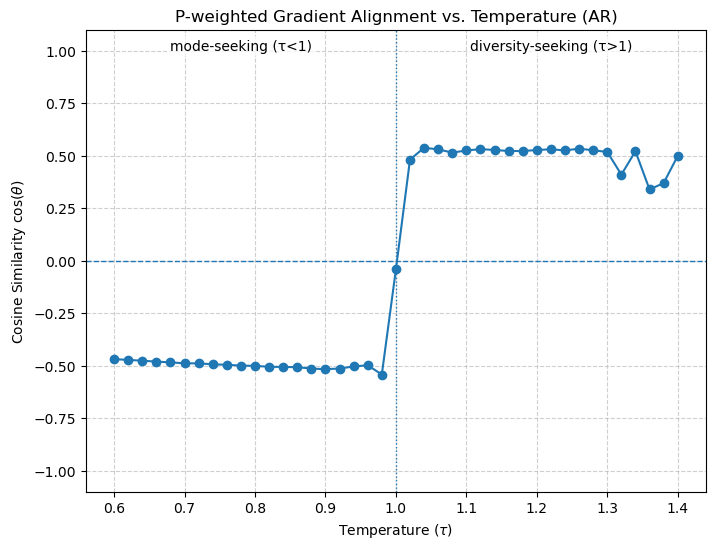

In [45]:
# ============================================================
# Neon toy with a 2D Autoregressive model + temperature (τ)
# ============================================================
# 1) Train tiny AR model p(x1) p(x2|x1) on a 2D Gaussian target.
# 2) Generate synthetic data with AR temperature τ (τ<1 mode-seeking, τ>1 diversity-seeking).
# 3) Short self-training on the synthetic set.
# 4) Neon merge: θ_neon = θ_r - w (θ_s - θ_r). Sweep w and plot FID (no CSV).
# 5) Compute P-weighted gradient cosine between real and synthetic gradients vs τ, and plot (no CSV).
# ============================================================

import math
import copy
from typing import Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.optim as optim
import scipy.linalg

# -------------------------
# Global Params
# -------------------------
device_str   = "cuda:0"
SEED         = 42
N_base       = 100
EPOCHS_BASE  = 1000        # AR converges fast in 2D
LR_BASE      = 5e-4
BATCH        = 2048

# Experiment 1 (FID vs w)
EPOCHS_LIST  = [50,250]   # self-train milestones
LR_FT        = 1e-4
N_aux        = 10**5
ws_sweep     = np.linspace(-1.0, 1.0, 41)
taus_syn     = [0.5, 1.6]  # τ<1: mode-seeking; τ>1: diversity-seeking
tau_eval     = 1.0         # fixed evaluation sampler temp
FID_SAMPLES  = 50_000

# Experiment 2 (cosine vs τ)
S_TAUS       = np.linspace(0.6, 1.4, 41)
N_pop        = 100_000
N_syn        = 100_000

# -------------------------
# Device / Seed
# -------------------------
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_rng(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

# -------------------------
# Target 2D Gaussian
# -------------------------
D = 2
sigma_ref = np.array([[2.0, 1.0],
                      [1.0, 2.0]], dtype=np.float64)
mu_ref    = np.zeros((D,), dtype=np.float64)

# -------------------------
# FID utilities
# -------------------------
def calculate_fid(mu, sigma, mu_r, sigma_r) -> float:
    """Closed-form FID for Gaussian features (here: identity feature space)."""
    m = np.square(mu - mu_r).sum()
    s, _ = scipy.linalg.sqrtm(sigma @ sigma_r, disp=False)
    if not np.isfinite(s).all():
        return float('inf')
    return float(np.real(m + np.trace(sigma + sigma_r - 2.0 * s)))

def fid_of_model_ar(model: nn.Module, nsamples: int, tau_eval: float = 1.0, seed: Optional[int] = None) -> float:
    """Reseeds RNG (if provided) so comparisons across w share identical noise."""
    if seed is not None:
        set_rng(seed)
    xs = model.sample(nsamples, tau=tau_eval, device=next(model.parameters()).device).cpu().numpy()
    if np.isnan(xs).any() or np.isinf(xs).any():
        return float('inf')
    return calculate_fid(xs.mean(0), np.cov(xs.T), mu_ref, sigma_ref)

# -------------------------
# AR model
# -------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64, nblocks=2):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.ReLU()]
        for _ in range(nblocks - 1):
            layers += [nn.Linear(hidden, hidden), nn.ReLU()]
        layers += [nn.Linear(hidden, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class ARGaussian2D(nn.Module):
    """
    p(x1, x2) = N(x1 | μ1, σ1^2) * N(x2 | μ2(x1), σ2(x1)^2)
    - head1: (μ1, logσ1) as free parameters
    - head2: MLP(x1) -> (μ2, logσ2)
    """
    def __init__(self, hidden=64, nblocks=2, min_log_std=-6.0, max_log_std=3.0):
        super().__init__()
        self.mu1 = nn.Parameter(torch.zeros(1))
        self.log_std1 = nn.Parameter(torch.zeros(1))  # starts σ1 ~ 1
        self.head2 = MLP(in_dim=1, out_dim=2, hidden=hidden, nblocks=nblocks)
        self.min_log_std = min_log_std
        self.max_log_std = max_log_std

    def _clamp_logstd(self, ls):
        return torch.clamp(ls, min=self.min_log_std, max=self.max_log_std)

    def nll(self, x: torch.Tensor) -> torch.Tensor:
        """Negative log-likelihood averaged over batch."""
        x1, x2 = x[:, 0], x[:, 1]

        # x1 ~ N(mu1, std1^2)
        mu1 = self.mu1.expand_as(x1)
        log_s1 = self._clamp_logstd(self.log_std1).expand_as(x1)
        s1 = torch.exp(log_s1)
        nll1 = 0.5 * (((x1 - mu1) / (s1 + 1e-9))**2 + 2.0 * log_s1 + math.log(2 * math.pi))

        # x2 | x1 ~ N(mu2(x1), std2(x1)^2)
        mu2, log_s2 = self.head2(x1.unsqueeze(1)).chunk(2, dim=-1)
        mu2 = mu2.squeeze(1)
        log_s2 = self._clamp_logstd(log_s2.squeeze(1))
        s2 = torch.exp(log_s2)
        nll2 = 0.5 * (((x2 - mu2) / (s2 + 1e-9))**2 + 2.0 * log_s2 + math.log(2 * math.pi))

        return (nll1 + nll2).mean()

    @torch.no_grad()
    def sample(self, nsamples: int, tau: float = 1.0, device=None):
        """
        Temperature τ scales std: σ' = τ·σ.
        τ<1 => mode-seeking; τ>1 => diversity-seeking.
        """
        device = device or next(self.parameters()).device

        # sample x1
        mu1 = self.mu1.expand(nsamples).to(device)
        log_s1 = torch.clamp(self.log_std1, self.min_log_std, self.max_log_std).expand(nsamples).to(device)
        s1 = torch.exp(log_s1) * tau
        eps1 = torch.randn(nsamples, device=device)
        x1 = mu1 + s1 * eps1

        # sample x2 | x1
        mu2, log_s2 = self.head2(x1.unsqueeze(1)).chunk(2, dim=-1)
        mu2 = mu2.squeeze(1)
        log_s2 = torch.clamp(log_s2.squeeze(1), self.min_log_std, self.max_log_std)
        s2 = torch.exp(log_s2) * tau
        eps2 = torch.randn(nsamples, device=device)
        x2 = mu2 + s2 * eps2

        return torch.stack([x1, x2], dim=1)

# -------------------------
# Neon merge helpers
# -------------------------
def compute_deltas(base: nn.Module, other: nn.Module) -> List[torch.Tensor]:
    """Return parameter deltas: (θ_s - θ_r) as a list of tensors."""
    with torch.no_grad():
        return [ps.detach().clone() - pr.detach().clone() for pr, ps in zip(base.parameters(), other.parameters())]

def merged_from_delta(base: nn.Module, deltas: List[torch.Tensor], w: float) -> nn.Module:
    """Create a fresh merged model: θ_r - w * (θ_s - θ_r)."""
    m = copy.deepcopy(base)
    with torch.no_grad():
        for p, d in zip(m.parameters(), deltas):
            p.copy_(p - w * d)
    return m

# -------------------------
# Train base AR on real data
# -------------------------
print("--- Training Base AR Model ---")
Xb = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, N_base).astype(np.float32))
base_model = ARGaussian2D(hidden=64, nblocks=2).to(device)
opt = optim.Adam(base_model.parameters(), lr=LR_BASE)

base_model.train()
for epoch in tqdm(range(EPOCHS_BASE), desc="Training Base"):
    for i in range(0, len(Xb), BATCH):
        xb = Xb[i:i+BATCH].to(device)
        loss = base_model.nll(xb)
        opt.zero_grad(); loss.backward(); opt.step()
base_model.eval()
print("Base AR model training complete.")

# Quick sanity FID at τ=1.0 (diagnostic only)
base_fid_diag = fid_of_model_ar(base_model, nsamples=FID_SAMPLES, tau_eval=tau_eval, seed=123)
print(f"Base FID (τ_eval=1.0, seed=123): {base_fid_diag:.6f}")

# ============================================================
# Experiment 1: FID vs. w under AR temperature (synthetic set)
# ============================================================
print("\n--- Running Experiment 1 (AR): FID vs. w ---")
results_fid = []

for tau in taus_syn:
    # 1) Synthetic set with temperature tau (τ<1 => mode-seeking)
    set_rng(777)  # ensure reproducible synthetic set
    Xs = base_model.sample(nsamples=N_aux, tau=tau, device=device).detach()

    # 2) Short FT on S
    aux_model = copy.deepcopy(base_model).train()
    opt_ft = optim.Adam(aux_model.parameters(), lr=LR_FT)
    max_epochs = max(EPOCHS_LIST)

    for epoch in range(1, max_epochs + 1):
        for i in range(0, len(Xs), BATCH):
            xb = Xs[i:i+BATCH].to(device)
            loss = aux_model.nll(xb)
            opt_ft.zero_grad(); loss.backward(); opt_ft.step()

        # 3) Evaluate at milestones with Neon merges
        if epoch in EPOCHS_LIST:
            aux_model.eval()
            deltas = compute_deltas(base_model, aux_model)

            # Fix RNG across the w sweep for low-variance FID comparisons
            eval_seed = 10_000 + epoch + int(1000 * tau)

            # (A) base FID with the same eval seed (so w=0 matches exactly)
            fid_base_same = fid_of_model_ar(base_model, nsamples=FID_SAMPLES, tau_eval=tau_eval, seed=eval_seed)
            results_fid.append({'epoch': epoch, 's_scale': tau, 'w': 0.0, 'fid': fid_base_same})

            # (B) sweep w excluding 0 (we already logged base above)
            for w in ws_sweep:
                if abs(w) < 1e-12:
                    continue
                merged_model = merged_from_delta(base_model, deltas, w).to(device).eval()
                fid = fid_of_model_ar(merged_model, nsamples=FID_SAMPLES, tau_eval=tau_eval, seed=eval_seed)
                results_fid.append({'epoch': epoch, 's_scale': tau, 'w': w, 'fid': fid})

            aux_model.train()

df_fid = pd.DataFrame(results_fid)
print("Experiment 1 finished.")

# ============================================================
# Experiment 2: P-weighted gradient cosine vs. τ
# ============================================================
print("\n--- Running Experiment 2 (AR): Cosine Similarity vs. τ ---")

def _avg_grad_over_dataset_ar(model, X, batch_size=2048):
    model.train()
    per_param_grads = [torch.zeros_like(p, device=device) for p in model.parameters()]
    n_batches = (len(X) + batch_size - 1) // batch_size
    for i in range(0, len(X), batch_size):
        xb = X[i:i+batch_size].to(device)
        model.zero_grad()
        loss = model.nll(xb)
        loss.backward()
        for acc, p in zip(per_param_grads, model.parameters()):
            if p.grad is not None:
                acc.add_(p.grad)
    for acc in per_param_grads:
        acc.div_(n_batches)
    return [g.detach() for g in per_param_grads]

def _estimate_adam_preconditioner_diagonal_ar(model, X, batch_size=2048, betas=(0.9, 0.999), eps=1e-8):
    beta2 = betas[1]
    model.train()
    v = [torch.zeros_like(p, device=device) for p in model.parameters()]
    steps = 0
    for i in range(0, len(X), batch_size):
        xb = X[i:i+batch_size].to(device)
        model.zero_grad()
        loss = model.nll(xb)
        loss.backward()
        for vv, p in zip(v, model.parameters()):
            if p.grad is not None:
                vv.mul_(beta2).addcmul_(p.grad, p.grad, value=(1.0 - beta2))
        steps += 1
    bc = 1.0 - (beta2 ** steps)
    v = [vv / bc for vv in v]
    return [1.0 / (torch.sqrt(vv) + eps) for vv in v]

def _dot_with_P(g1_parts, g2_parts, P_diag_parts):
    s = 0.0
    for g1, g2, pd in zip(g1_parts, g2_parts, P_diag_parts):
        s += torch.sum(g1 * (pd * g2))
    return float(s.item())

def _norm_with_P(g_parts, P_diag_parts):
    norm_sq = 0.0
    for g, pd in zip(g_parts, P_diag_parts):
        norm_sq += torch.sum(g * (pd * g))
    return math.sqrt(max(float(norm_sq.item()), 1e-18))

# Build a big real-data set for gradient estimation
X_pop = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, size=N_pop).astype(np.float32))

g_d_pop_parts = _avg_grad_over_dataset_ar(base_model, X_pop)
P_adam_diag_parts = _estimate_adam_preconditioner_diagonal_ar(base_model, X_pop)
norm_d = _norm_with_P(g_d_pop_parts, P_adam_diag_parts)

cosine_similarities = []
for tau in tqdm(S_TAUS, desc="Sweeping τ for Cosine Similarity"):
    set_rng(2024 + int(1000 * tau))
    X_syn = base_model.sample(nsamples=N_syn, tau=float(tau), device=device)
    g_s_parts = _avg_grad_over_dataset_ar(base_model, X_syn)
    inner = _dot_with_P(g_d_pop_parts, g_s_parts, P_adam_diag_parts)
    norm_s = _norm_with_P(g_s_parts, P_adam_diag_parts)
    cos_sim = inner / (norm_d * norm_s + 1e-18)
    cosine_similarities.append(cos_sim)

df_align = pd.DataFrame({'s_scale': S_TAUS, 'cosine_similarity': cosine_similarities})  # 's_scale' stores τ
print("Experiment 2 finished.")

# ============================================================
# Plotting 
# ============================================================
print("\n--- Plotting Results (AR) ---")

def tau_tag(tau: float) -> str:
    return "mode-seeking" if tau < 1.0 else "diversity-seeking"

# -------- FID vs w (two models only; add vertical line at w=0) --------
for epoch in sorted(df_fid['epoch'].unique()):
    plt.figure(figsize=(8, 6))
    epoch_df_full = df_fid[df_fid['epoch'] == epoch]

    # Hide the w=0 base points so only the τ curves remain
    epoch_df = epoch_df_full[~np.isclose(epoch_df_full['w'], 0.0)]

    # Plot τ curves
    for tau in sorted(epoch_df['s_scale'].unique()):
        subset = epoch_df[epoch_df['s_scale'] == tau]
        label = fr"$\tau={tau:.2f}$ — {tau_tag(float(tau))}"
        plt.plot(subset['w'], np.log10(subset['fid']), label=label)

    # Vertical reference at w=0 (like diffusion plot)
    plt.axvline(0, linestyle=':', linewidth=1, label='w=0 reference')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(f"FID vs. Merge Weight ($w$) after {epoch} FT Epochs (AR)")
    plt.xlabel("Merge Weight ($w$)")
    plt.ylabel(r"$\log_{10}(\mathrm{FID})$")
    plt.legend(title="Sampler (τ)")
    plt.show()

# -------- Cosine similarity vs τ (annotations at top) --------
plt.figure(figsize=(8, 6))
plt.plot(df_align['s_scale'], df_align['cosine_similarity'], marker='o', linestyle='-')
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.axvline(1.0, linestyle=":", linewidth=1)

plt.xlabel(r"Temperature ($\tau$)")
plt.ylabel(r"Cosine Similarity $\cos(\theta)$")
plt.title("P-weighted Gradient Alignment vs. Temperature (AR)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-1.1, 1.1)

# Top-of-axes region tags (fixed position)
ax = plt.gca()
ax.text(0.25, 0.98, "mode-seeking (τ<1)", transform=ax.transAxes,
        ha="center", va="top", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
ax.text(0.75, 0.98, "diversity-seeking (τ>1)", transform=ax.transAxes,
        ha="center", va="top", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
plt.show()
